# Imports

In [10]:
import os
import sys
sys.path.insert(0,'..')
import torch
import pickle
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import time

from utils import iterate_minibatches, ResultsContainer
from confusionmatrix import ConfusionMatrix
from metrics_mc import gorodkin, IC
from model import ABLSTM


def model_load(fn):
    global model, criterion, optimizer
    with open(fn, 'rb') as f:
        model, criterion, optimizer = torch.load(f, map_location='cpu')
        



## Load model and results

In [11]:
n_class = 10
batch_size = int(128)
seq_len = 1000
n_hid = int(256)


model_load("../save/best_model_Mar_04-14_48.pt")

with open('../save/best_results_Mar_04-14_48', 'rb') as f:
    results = pickle.load(f)
    
alphas = results.alphas
targets = results.targets
epochs = results.epochs + 1
loss_training = results.loss_training
loss_validation = results.loss_validation
acc_training = results.acc_training
acc_validation = results.acc_validation
best_cf_val = results.best_cf_val
best_val_acc = results.best_val_acc

## Import data

In [12]:
# Load data
print("Loading data...")
test_data = np.load("../data/Hoglund/test.npz")
train_data = np.load("../data/Hoglund/train.npz")

# Test set
X_test = test_data['X_test']
y_test = test_data['y_test']
mask_test = test_data['mask_test']

# Initialize output vectors from test set
complete_alpha = np.zeros((X_test.shape[0],seq_len))
complete_context = np.zeros((X_test.shape[0],n_hid*2))
complete_test = np.zeros((X_test.shape[0],n_class))

# Training set
X_train = train_data['X_train']
y_train = train_data['y_train']
mask_train = train_data['mask_train']
partition = train_data['partition']
print("Loading complete!")

Loading data...
Loading complete!


# Results

## Model loss and accuracy

In [13]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

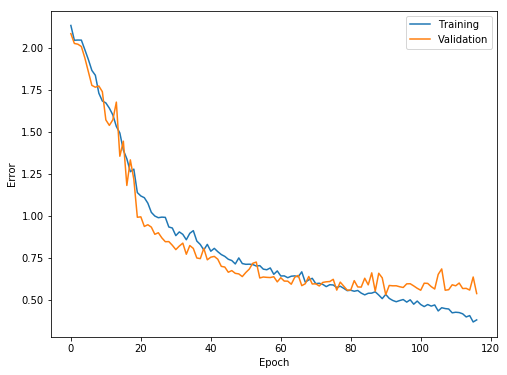

In [14]:
x_axis = range(epochs)
plt.figure(figsize=(8,6))
plt.plot(x_axis,loss_training)
plt.plot(x_axis,loss_validation)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training','Validation'));

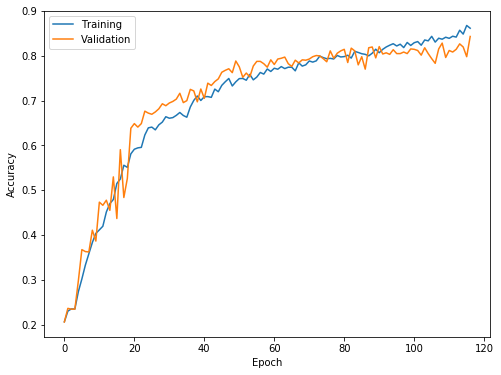

In [15]:
plt.figure(figsize=(8,6))
plt.plot(x_axis,acc_training)
plt.plot(x_axis,acc_validation)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training','Validation'));

## Confusion matrix

In [16]:
val_index = np.where(partition == 1)

X_val = X_train[val_index].astype(np.float32)
y_val = y_train[val_index].astype(np.int32)
mask_val = mask_train[val_index].astype(np.float32)

print('| Valid | acc {:.2f}% | Gorodkin {:2.2f} | IC {:2.2f}' 
          ' |'.format(best_val_acc*100, gorodkin(best_cf_val),IC(best_cf_val)))


| Valid | acc 84.29% | Gorodkin 0.81 | IC 0.71 |


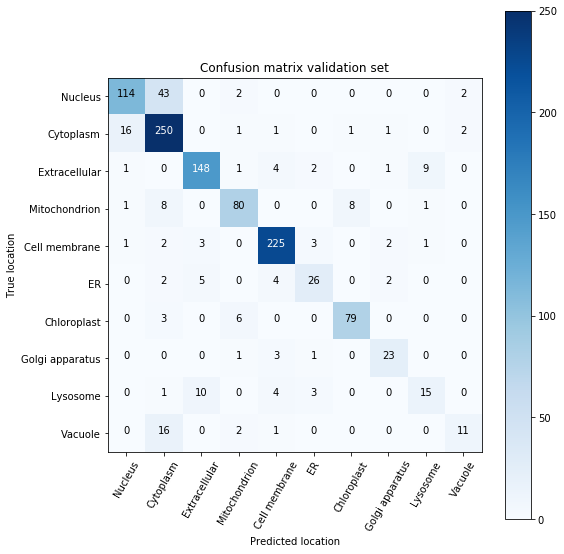

In [17]:
plt.figure(figsize=(8,8))

cmap=plt.cm.Blues   
plt.imshow(best_cf_val, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = best_cf_val.max() / 2.
for i, j in itertools.product(range(best_cf_val.shape[0]), range(best_cf_val.shape[1])):
    plt.text(j, i, best_cf_val[i, j],
             horizontalalignment="center",
             color="white" if best_cf_val[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location');

## Attention

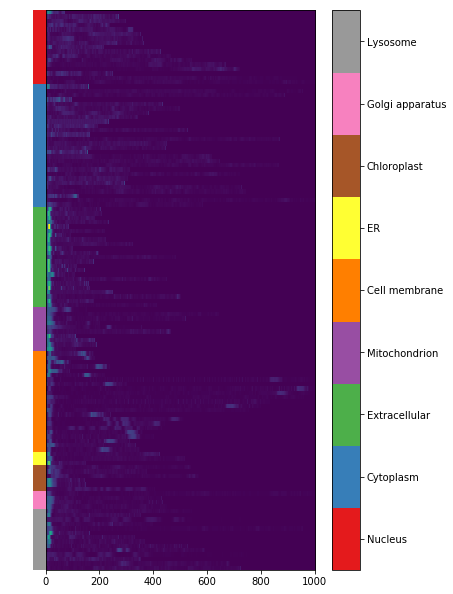

In [18]:
sort_ind = np.argsort(targets)
alphas_1 = alphas[:,:][sort_ind]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15));
labels_plot = ax1.imshow(targets[sort_ind].reshape(128,1),cmap=plt.get_cmap('Set1'))
ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(classes)
att_plot = ax2.imshow(alphas_1, aspect='auto')
ax2.yaxis.set_visible(False)
plt.tight_layout(pad=25, w_pad=0.5, h_pad=1.0)